In [2]:
!pip install sk-video

     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [3]:
%matplotlib inline

from google.colab import files, drive    # upload
import numpy as np                       # mathematical calculations
from io import BytesIO                   # reading files
from PIL import Image             # image processing library
import matplotlib.pyplot as plt   # plotting library
import glob                        # find all files in a directory
from skvideo import io
from moviepy.editor import *
from joblib import Parallel, delayed
import cv2

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1761280/45929032 bytes (3.8%)4915200/45929032 bytes (10.7%)7684096/45929032 bytes (16.7%)10575872/45929032 bytes (23.0%)13672448/45929032 bytes (29.8%)16900096/45929032 bytes (36.8%)20398080/45929032 bytes (44.4%)24010752/45929032 bytes (52.3%)27549696/45929032 bytes (60.0%)30851072/45929032 bytes (67.2%)34316288/45929032 bytes (74.7%)37691392/45929032 bytes (82.1%)

In [4]:
drive.mount('drive')
img = Image.open("/content/drive/MyDrive/Colab Notebooks/coins.png")
im = np.array(img)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


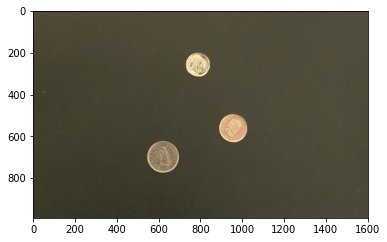

In [5]:
plt.imshow(im)

In [6]:
def greyscale(image):
  """
  Given a coloured rgb image, return the greyscale image.
  input:
    image - np array 3d
  output:
    grey - np array 2d
  """
  grey = 0.3*image[:,:,0] + 0.59*image[:,:,1] + 0.11*image[:,:,2]
  return grey

In [7]:
grey_im = greyscale(im)

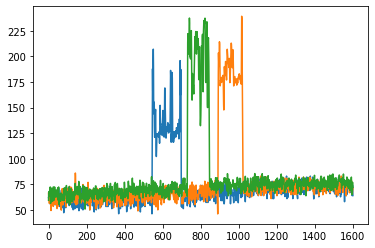

In [8]:
plt.plot(grey_im[700,:])
plt.plot(grey_im[580,:])
plt.plot(grey_im[250,:])

250.33999999999997 28.03 255.0 0.0


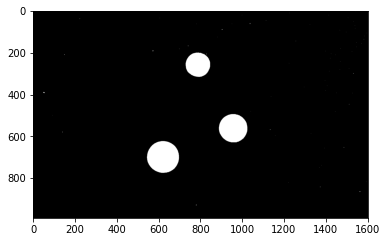

In [9]:
bin_img = grey_im.copy()
bin_img[bin_img < 90] = 0
bin_img[bin_img >= 90] = 255
plt.imshow(bin_img, cmap='gray')
print(grey_im.max(), grey_im.min(), bin_img.max(), bin_img.min())

In [10]:
# Image Smoother
def smooth(image):
  """
  takes in a greyscale image and returns the smoothed result

  Input;
   image: 2d numpy array that we want to smooth


  Output:
    output: 2d numpy array that is the smoothed result
  """
  n_im = image.copy().astype(np.float32)
  z = image.shape[0]
  y = image.shape[1]
  for i in range(1, z-1):
    for x in range(1, y-1):
      avg = image[i, x] + image[i, x + 1] + image[i, x - 1]
      avg += image[i - 1, x - 1] + image[i - 1, x] + image[i - 1, x + 1]
      avg += image[i + 1, x + 1] + image[i + 1, x] + image[i + 1, x - 1]
      avg = avg * 1/9
      n_im[i, x] = avg
  return n_im

# details
def detail(image, smoothed_im):
  details = np.abs(image - smoothed_im)
  return details

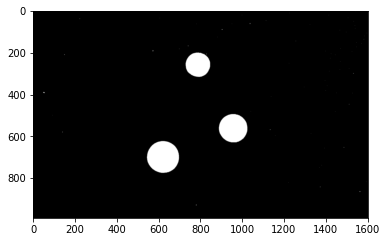

In [11]:
smoothed = smooth(bin_img)
plt.imshow(smoothed, cmap = "gray")

(-0.5, 1601.5, 989.5, -0.5)

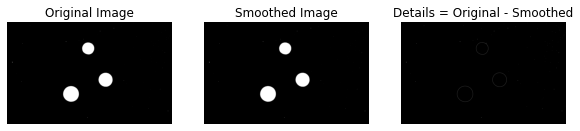

In [12]:
details = detail(bin_img, smoothed)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4])
ax1.set_title("Original Image")
ax2.set_title("Smoothed Image")
ax3.set_title("Details = Original - Smoothed")

im1 = ax1.imshow(bin_img, cmap="gray")
im2 = ax2.imshow(smoothed, cmap="gray")
im3 = ax3.imshow(details, cmap="gray")

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

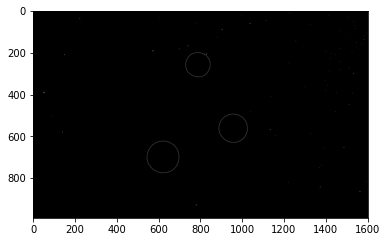

In [13]:
plt.imshow(details, cmap='gray')

In [14]:
class CircleModel(object):
  """Represents a circle model using its center point and radius"""
  def __init__(self, center_x, center_y, radius):
    self.x = center_x
    self.y = center_y
    self.r = radius
  def __str__(self):
    display="CirleModel: x={}, y={}, r={}".format(self.x, self.y, self.r)
    return display
  def circle(self):
    """
    Compute perfect circle using model
    gernerate x ourselves {nd.array}
    """
    #Step 1: denerate a appropriate x array
    x = np.linspace(self.x - self.r, self.x + self.r, num=101, endpoint=True)
    #Step 2: Generate y given equation
    y_p = self.y + np.sqrt(self.r**2 - np.square(x-self.x))
    y_m = self.y - np.sqrt(self.r**2 - np.square(x-self.x))
    y = np.concatenate((y_p, np.flip(y_m)))
    x = np.concatenate((x, np.flip(x)))
    return np.squeeze(x), np.squeeze(y)
  
  def compute_error(self, x, y):
    """
    Given a point, comput ewhat the error it is with the closest point on the circle
    """
    y_p = self.y + np.sqrt(self.r**2 - np.square(x-self.x))
    y_m = self.y - np.sqrt(self.r**2 - np.square(x-self.x))
    return min(np.square(y-y_p), np.square(y-y_m))
  @staticmethod
  def estimate_circle(p1, p2, p3):
    """Given 3 points find the est_x, est_y, r for the fiven 3 points"""
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    x3 = p3[0]
    y3 = p3[1]
    a = x1*(y2 - y3) - y1*(x2 - x3) + x2 * y3 - x3 * y2
    b = (x1**2 + y1**2) * (y3 - y2) + (x2**2 + y2**2) * (y1 - y3) + (x3**2 + y3**2) * (y2 - y1)
    c = (x1**2 + y1**2) * (x2 - x3) + (x2**2 + y2**2) * (x3 - x1) + (x3**2 + y3**2) * (x1 - x2)
    d = (x1**2 + y1**2) * (x3 * y2 - x2 * y3) + (x2**2 + y2**2) * (x1 * y3 - x3 * y1) + (x3**2 + y3**2) * (x2 * y1 - x1 * y2)
    est_x = - b/(2 * a)
    est_y = - c/(2 * a)
    est_r = np.sqrt((b**2 + c**2 - 4 * a * d)/(4 * a**2))
    return CircleModel(est_x, est_y, est_r)

In [15]:
#c = CircleModel(2, 3, 2)
c = CircleModel.estimate_circle((1, 0), (0, 1), (-1, 0))
print(c)

CirleModel: x=0.0, y=0.0, r=1.0


In [16]:
p = [1, 1.2]
error = c.compute_error(p[0], p[1])
print("Error", error)

Error 1.44


CirleModel: x=0.0, y=0.0, r=1.0


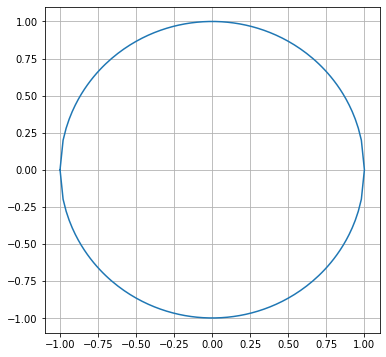

In [17]:
fig = plt.figure(figsize=[6,6])
x, y = c.circle()
plt.plot(x, y)
plt.grid()
print(c)

In [18]:
crop = details[500: 800, 500: 800]
crop2 = details[100:400, 600:900]
crop3 = details[400:700,800:1100]
patches = {
    0: crop, 
    1: crop2,
    2: crop3,
}
# patch position
patch_l = {
    0: [500,500],
    1: [100,600],
    2: [400,800],
}

(-0.5, 299.5, 299.5, -0.5)

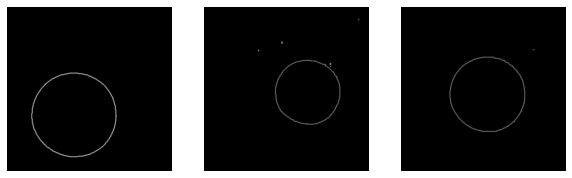

In [19]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4])

im1 = ax1.imshow(crop, cmap="gray")
im2 = ax2.imshow(crop2, cmap="gray")
im3 = ax3.imshow(crop3, cmap="gray")

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

In [20]:
def find_coords(patch):
  """
  Converst 2D binary edge detected image into two arrays of the c and y locations of the points that are greater than 0
  
  Input:
  patch - 2d edge detected image

  Output:
  x - array of x coordinates that have a value greater than 0 
  y - array of y coordinates that have a value greater than 0 
  """
  x = []
  y = []
  for ind, i in enumerate(patch):
    for n, z in enumerate(i):
      if patch[ind, n] > 0:
        x.append(n)
        y.append(ind)
  return np.array(x), np.array(y)



In [21]:
x, y = find_coords(patches[0])
print(x)
print(y)

[112 113 114 ... 127 128 129]
[121 121 121 ... 274 274 274]


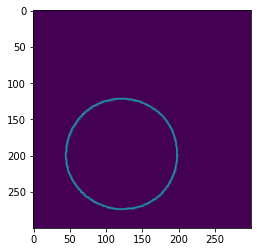

In [22]:
plt.scatter(x, y, s= 0.1, alpha= 0.3)
plt.imshow(patches[0])

In [23]:
def circle_ransac(x2fit, y2fit, patch, itr):
  """
  Function that fits input cartesian coord data to a circle model

  Ouput:
    model
    average error
  """
  #Original Circle
  fin = plt.figure(figsize=[12,4])
  plt.imshow(patch, cmap="gray")

  #Set Inlier restrictions adn Thresholds
  min_inlier_percentage = 0.55 # minimum percentage of inlier points
  min_inlier = min_inlier_percentage*x2fit.size # minimum number of inlier points
  err_threshold = 20 # max distance an inlier point can be away from the model
  inliers_indices = []
  inlier_model = False
  best_error = 1000000
  best_model = CircleModel(0,0,0) # initializing with the same return type
  best_itr = None

  if x2fit.size == 0:
    return best_model, 0

  for i in range(1, itr):
    #otherwise, solve with 3 random points
    #S1: select random subset of pts from data in inlier list emtpy
    ind1 = np.random.randint(0, x2fit.size)
    ind2 = np.random.randint(0, x2fit.size)
    ind3 = np.random.randint(0, x2fit.size)
    

    if ind1 == ind2 or ind2 == ind3 or ind1 == ind3:
      continue

    p1 = [x2fit[ind1], y2fit[ind1]]
    p2 = [x2fit[ind2], y2fit[ind2]]
    p3 = [x2fit[ind3], y2fit[ind3]]
    #S2 Find model
    c = CircleModel.estimate_circle(p1, p2, p3)
    x,y = c.circle()



    #S3 Test if it passes min_inlier
    num_inliers = 0
    inliers_indices = []
    total_error = 0
    
    # Finds amount of inliers
    # error equal to sum of absolute distances from expected value to the real value
    for j in range(x2fit.size):
      d = abs(c.compute_error(x2fit[j], y2fit[j]))
      if d <= err_threshold:
        # Count number of inliers
        num_inliers += 1
        # Store indices of inliers
        inliers_indices.append(j)
        # Add to error
        total_error += d
    avg_error = total_error/len(x)
    # If yes, then this is a valid model, plot
    # Check if num_inliers is greater than min_inliers
    if num_inliers >= min_inlier:
      inlier_model = True
      
      #save best model
      if abs(avg_error) < best_error:
        best_error = avg_error
        best_model = c
        best_itr = i

  x,y = best_model.circle()
  plt.plot(x, y, label="itr={0}, c={1}, err={2:2.2f}".format(best_itr, str(c), avg_error))
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  return best_model, best_error






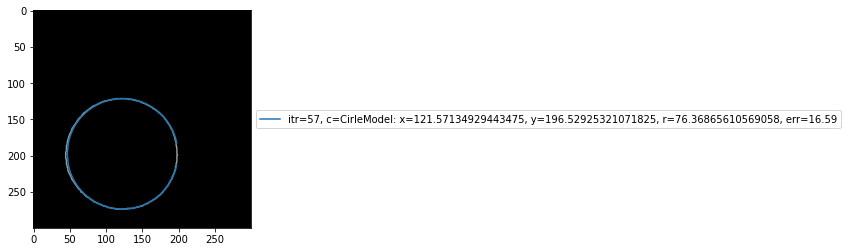

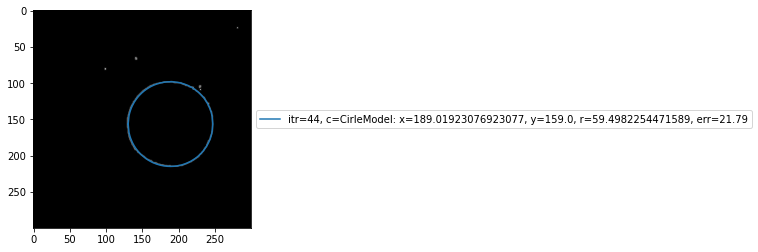

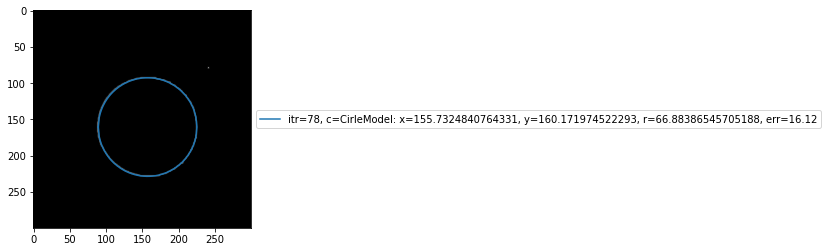

In [24]:
 models = {}
 for ind, i in enumerate(patches.values()): 
  x, y = find_coords(patches[ind])
  bm, be = circle_ransac(x, y, patches[ind], 101)
  x,y = bm.circle()
  models[ind] = [x, y, bm, be]

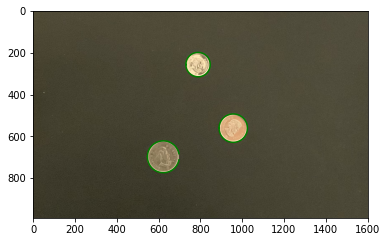

In [25]:
plt.imshow(im)
for ind,i in enumerate(models.values()):
  plt.plot(i[0] + patch_l[ind][1], i[1] + patch_l[ind][0], c="green")

In [26]:
path = "/content/drive/MyDrive/Colab Notebooks/esther-eye.avi"

clip = VideoFileClip(path)
clip.ipython_display(width=380)

100%|█████████▉| 500/501 [00:02<00:00, 242.68it/s]


In [27]:
videodata = io.vread(path)
print(videodata.shape, type(videodata))

(499, 350, 650, 3) <class 'numpy.ndarray'>


In [28]:
def pupil_binarize(video):
  """
  binarize every frame in video
  """
  bin_vid = []
  f, w, l, d = video.shape
  for i in range(0, f):
    grey_im = greyscale(video[i])
    bin_im = grey_im.copy()
    bin_im[bin_im < 40] = 0
    bin_im[bin_im >= 40] = 255
    bin_vid.append(bin_im)
  return np.array(bin_vid)
  

In [29]:
bin_vid = pupil_binarize(videodata)

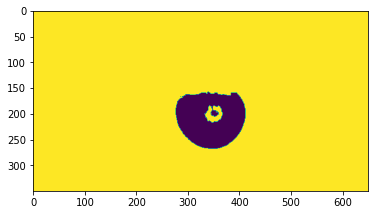

In [30]:
plt.imshow(bin_vid[245])

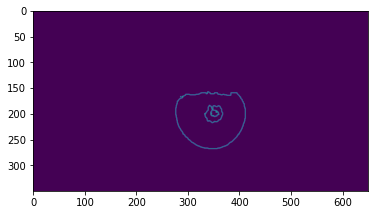

In [31]:
smoothed = smooth(bin_vid[245])
details = detail(bin_vid[245], smoothed)
plt.imshow(details)

In [32]:
def edge_detection(video):
  """
  input:
    - video
  output:
    - edge detected video
  """
  edge_detected = []
  bin_vid = pupil_binarize(video)
  f, w, l, d = video.shape
  for i in range(0, f):
    smoothed = smooth(bin_vid[i])
    details = detail(bin_vid[i], smoothed)
    edge_detected.append(details)
  return np.array(edge_detected)


In [33]:
edge_detected_vid = edge_detection(videodata[0:260, :, :, :])

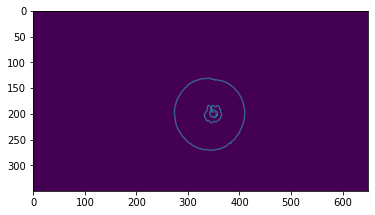

In [34]:
plt.imshow(edge_detected_vid[50])

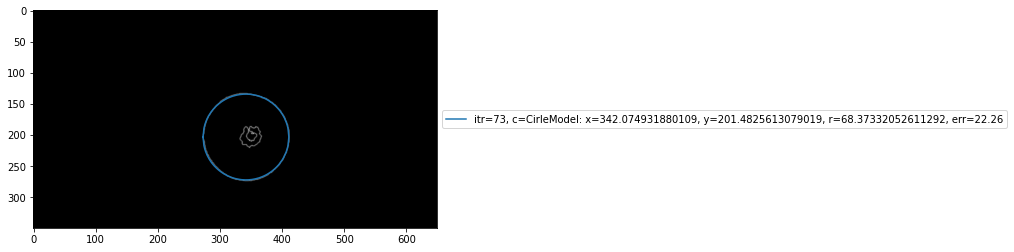

In [35]:
  x, y = find_coords(edge_detected_vid[0])
  bm, be = circle_ransac(x, y, edge_detected_vid[0], 101)
  x,y = bm.circle()

In [36]:
def pupil_tracker(video):
  """
  Tracks the size of the pupil over time in the video
  input:
    video: 4D nd.array
  Output:
    dict mapping frame number to pupii radius
  """
  results = {}
  e_d = edge_detection(video)
  for ind, i in enumerate(e_d):
    print(ind)
    x, y = find_coords(i)
    bm, be = circle_ransac(x, y, i, 101)
    results[ind] = [bm, bm.r]
  return results


In [37]:
lb = 45
ub = 60

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


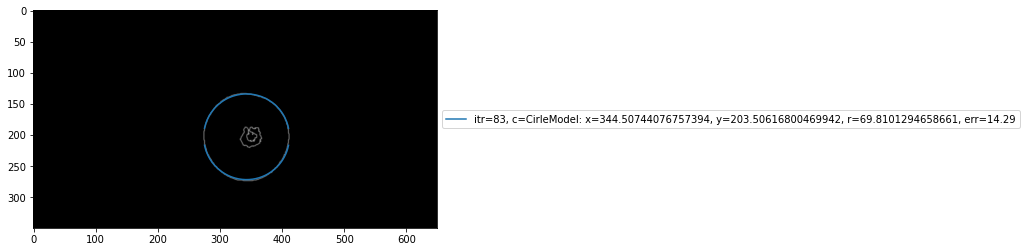

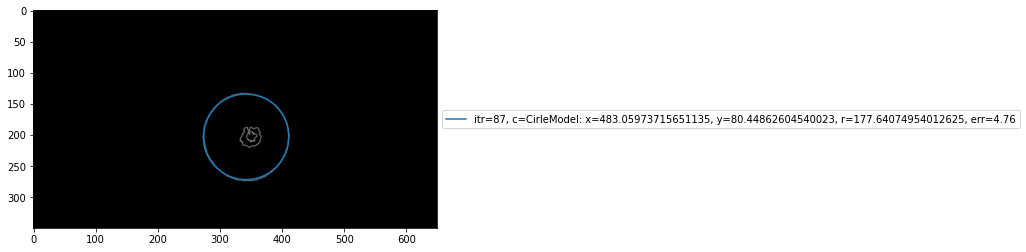

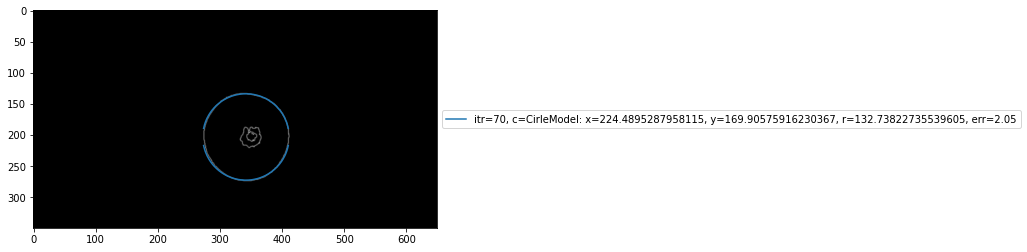

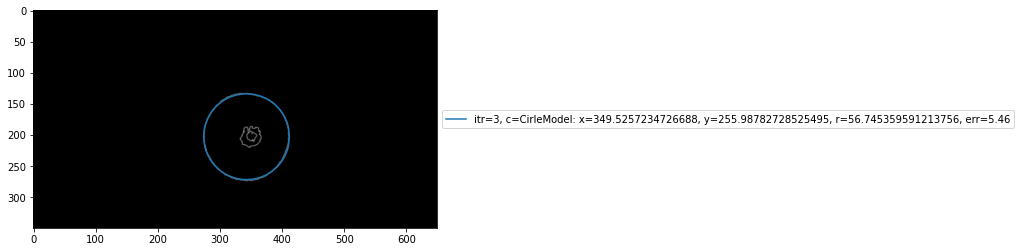

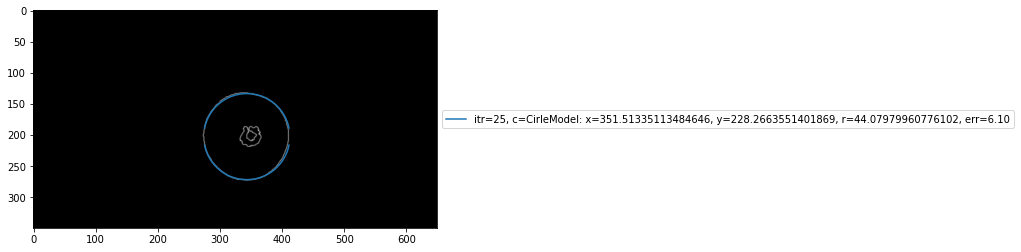

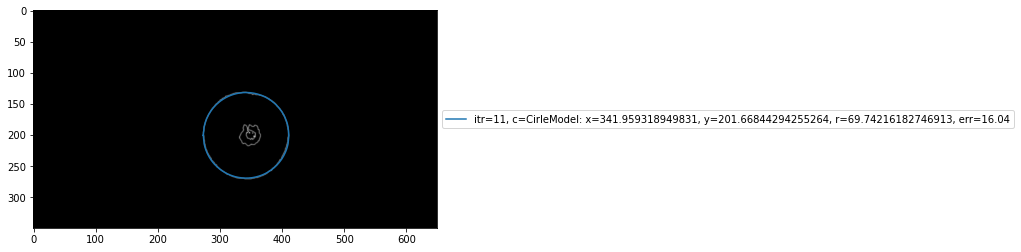

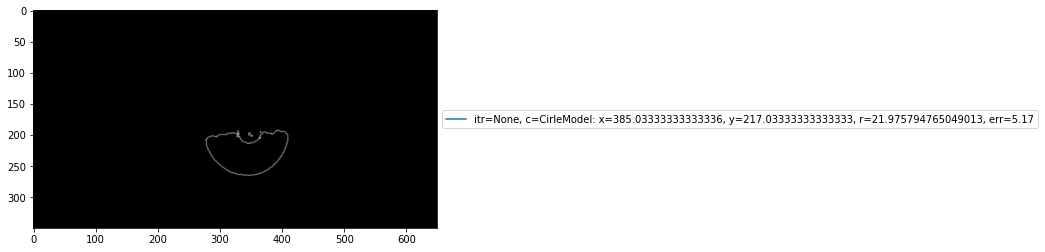

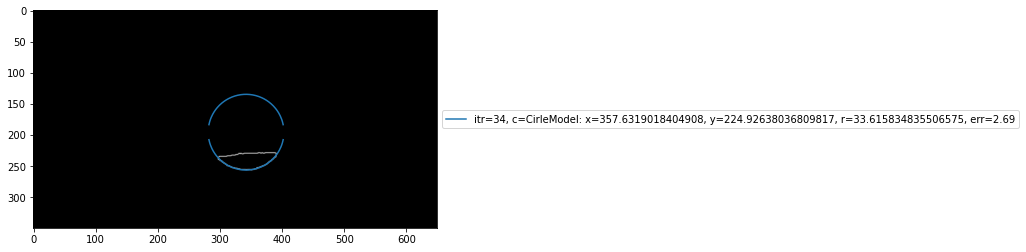

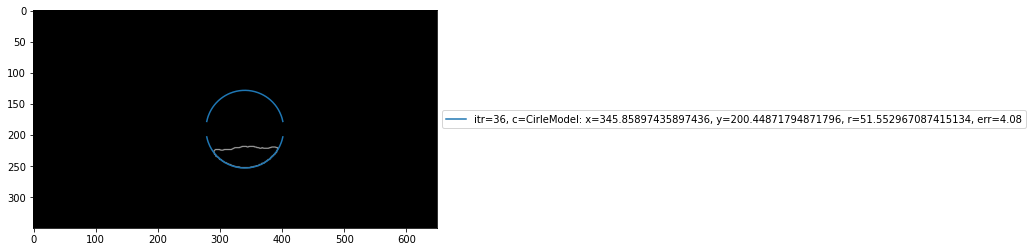

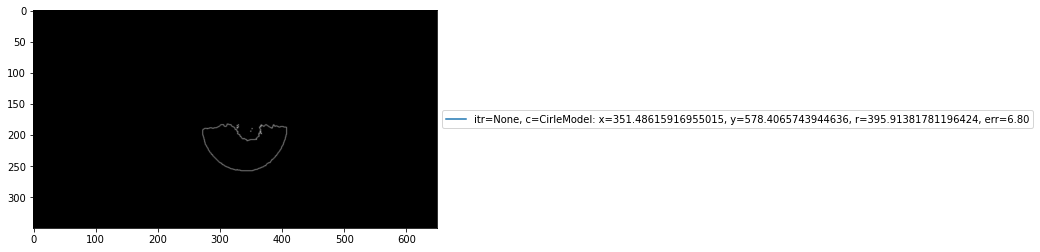

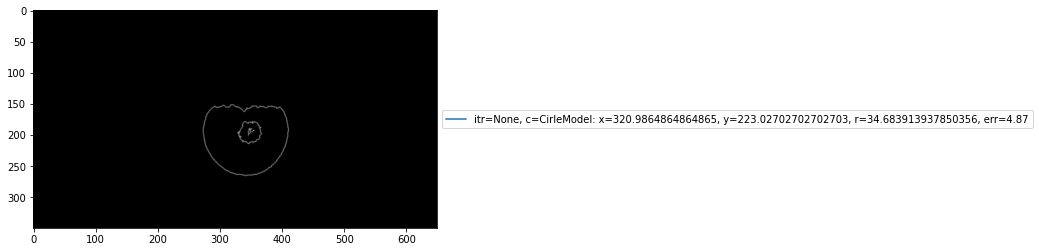

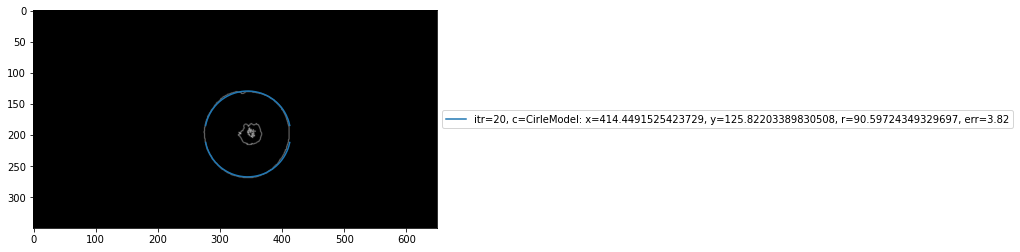

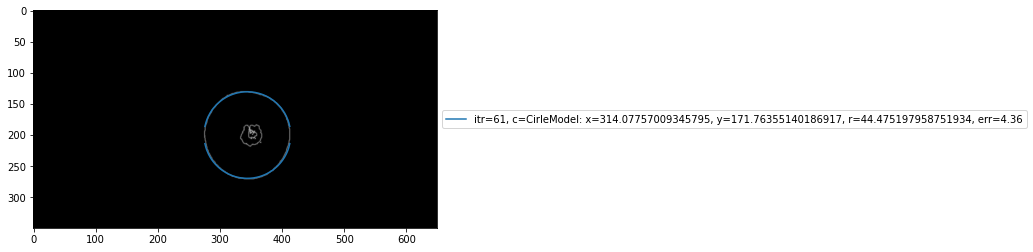

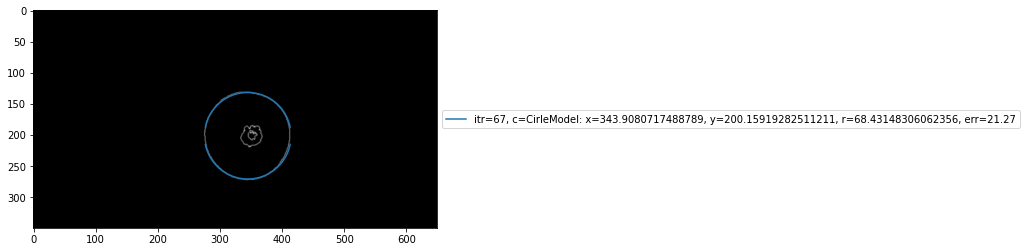

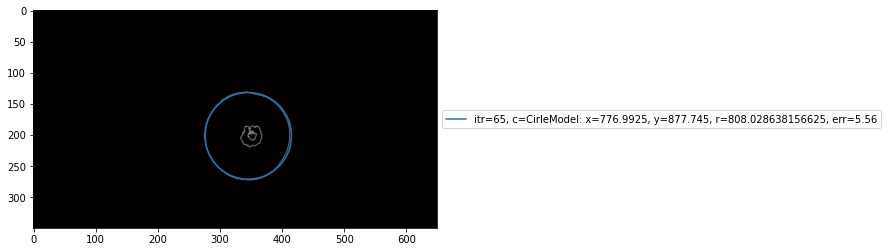

In [38]:
r = pupil_tracker(videodata[lb:ub, :, :, :])

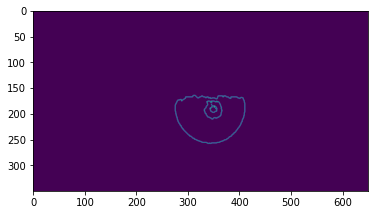

In [39]:
plt.imshow(edge_detected_vid[252])

Blink: from open to closed around 3 frames

In [40]:
def running_average(x, y, n, window, factor):
  a_x = []
  a_y = []
  for i in range(0, len(x) - window):
    a = y[i] + y[i + 1] + y[i + 2]
    a = a/window
    a_x.append(i * factor + n + int(window/2))
    a_y.append(a)
  return a_x, a_y

In [41]:
f = 1
results = Parallel(n_jobs=4, verbose=10)(delayed(pupil_tracker)(videodata[i:i+1, :, :, :]) for i in range(0, 499, f))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 13.6min
[Parallel(

In [42]:
print(type(results[0]))

<class 'dict'>


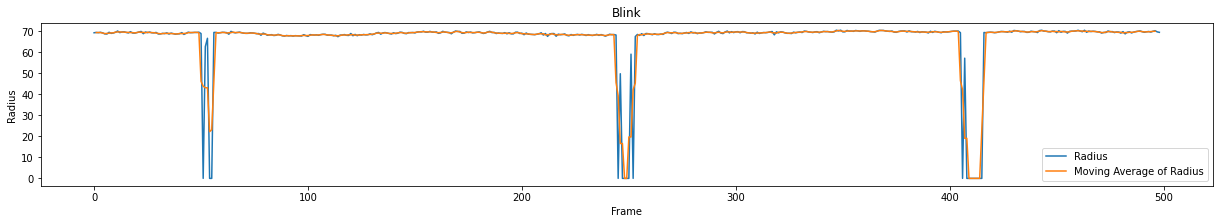

In [43]:
r_x = []
r_y = []
for ind, i in enumerate(results):
  r_x.append(ind * f)
  r_y.append(i[0][0].r)

ax, ay = running_average(r_x, r_y, 0, 3, f)

r_x = np.array(r_x)
r_y = np.array(r_y)
ax = np.array(ax)
ay = np.array(ay)

fig = plt.figure(figsize=[21, 3])
plt.title("Blink")
plt.xlabel("Frame")
plt.ylabel("Radius")
plt.plot(r_x, r_y, label='Radius')
plt.plot(ax, ay, label="Moving Average of Radius")
plt.legend()

Blink length detection 

In [44]:
def blink(x, y, t, factor):
  y = list(y)
  d = {}
  n = 0
  for i in range(len(y)):
    if n != 0:
      n -= 1
    elif y[i] < t:
      n = 0
      for j in range(len(y) - i):
        if y[i + j] < t:
          n += 1
        else:
          break
      d[x[i] * factor] = n * factor
  return d


In [45]:
d = blink(ax, ay, 60, f)
blnk = list(d.keys())
blnk_length = list(d.values())
blnk_length = [int(i) for i in blnk_length]
l = []
for i in range(0, len(blnk)):
  for j in range(0, blnk_length[i]):
    l.append(blnk[i] + j)
print(l)

[50, 51, 52, 53, 54, 55, 56, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416]


In [46]:
print(results)

[{0: [<__main__.CircleModel object at 0x7f197c549a50>, 69.34856384219418]}, {0: [<__main__.CircleModel object at 0x7f197b41fd90>, 69.52267503979854]}, {0: [<__main__.CircleModel object at 0x7f197b4214d0>, 69.38680019947927]}, {0: [<__main__.CircleModel object at 0x7f197b3f6610>, 69.58255191152114]}, {0: [<__main__.CircleModel object at 0x7f197b3f61d0>, 69.29992397900031]}, {0: [<__main__.CircleModel object at 0x7f197b3f6f90>, 68.80621856298053]}, {0: [<__main__.CircleModel object at 0x7f197b3f6850>, 68.74966778416484]}, {0: [<__main__.CircleModel object at 0x7f197b421b90>, 69.58478807043358]}, {0: [<__main__.CircleModel object at 0x7f197b3f6390>, 69.05699115467021]}, {0: [<__main__.CircleModel object at 0x7f197b421790>, 69.24150312792852]}, {0: [<__main__.CircleModel object at 0x7f197b41f590>, 69.58159671576782]}, {0: [<__main__.CircleModel object at 0x7f197b3f6d50>, 70.19544036070454]}, {0: [<__main__.CircleModel object at 0x7f197b3f6bd0>, 69.41677981793563]}, {0: [<__main__.CircleMod

In [47]:
path = "/content/drive/MyDrive/Colab Notebooks/esther-eye.avi"

clip = VideoFileClip(path)
clip.ipython_display(width=380)

100%|█████████▉| 500/501 [00:02<00:00, 236.27it/s]


In [48]:
videodata = io.vread(path)
print(videodata.shape, type(videodata))

(499, 350, 650, 3) <class 'numpy.ndarray'>


<Figure size 432x288 with 0 Axes>

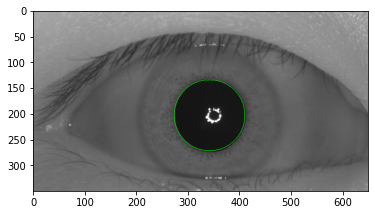

In [49]:
# Part 1: Draw circle on frame
plt.clf()
fig = plt.figure()
i = 20
m = results[i][0][0]
c = cv2.circle(videodata[i, :, :, :],(int(m.x),int(m.y)), int(m.r), (0,255,0), 1)
plt.imshow(c)


In [50]:
# Part 2: Make a video
frameSize = (650, 350)
num_frames = 499 # 499 for all frames
out = cv2.VideoWriter("/content/drive/MyDrive/Colab Notebooks/"+'output_video.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30, frameSize)
for i in range(0,num_frames):
    m = results[i][0][0]
    c = cv2.circle(videodata[i, :, :, :],(int(m.x),int(m.y)), int(m.r), (0,255,0), 1)
    out.write(c)

out.release()

In [51]:
path = "/content/drive/MyDrive/Colab Notebooks/"+"output_video.mp4" 
clip = VideoFileClip(path)
clip.ipython_display(width=400)

100%|██████████| 499/499 [00:01<00:00, 253.23it/s]


In [52]:
videodata = io.vread(path)
print(videodata.shape, type(videodata))

(499, 350, 650, 3) <class 'numpy.ndarray'>


499
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 24

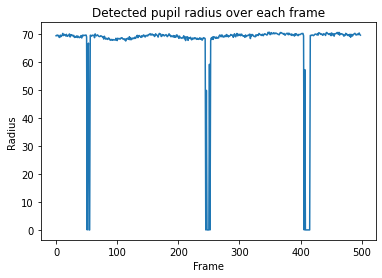

In [53]:
plt.title("Detected pupil radius over each frame")
plt.xlabel("Frame")
plt.ylabel("Radius")
plt.plot(r_x, r_y, label='Radius')
print(len(results))
print(r_x)